TODO:
Divide into strips w/ grand staff
Calculate median pixel value in each row (close to 0, then very high etc)
Use this row median graph, cut into indivdiual staffs, then go into coord system by mapping vertical position to one note (e.g. right goes C4 to B6),
left goes from C2 to B3

How can we est the location of the 5 peaks + do linear interp? Lowest peak = E4, then G4, then B4, D5, F5.

Touch base with Mint so she can point to appropriate code and you can try using it after fixing the graph  to log. 

Use code Mint points you to in order to find a way to convert each score into individual staff lines (e.g. just RH, just LH), calculate median of each row, est location of 5 peaks, then do linear interpolation w/ built-in SKLearn/Numpy to d o a linear interp of the 5 

Give  it pairs of x,y coords. So like notes 0,2,4,6,8, ... up to 20 so 21-dim vector. y-axis is which note out of 21, then x-axis is the vertical pixel position from the bottom (e.g. 35 pixels until then)--use lin interp to convert from vertical pixel position to discretized note value. Then can do a look up in a hash table or smth. 

1. Pull out individual strips from a page of sheet music
2. Mint's intial code for above things--try to est conversion from vertical pixel position to discretized note value. 

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

In [2]:
test_image = Image.open(os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-2.png")).convert('L')

In [3]:
img_array = np.array(test_image)

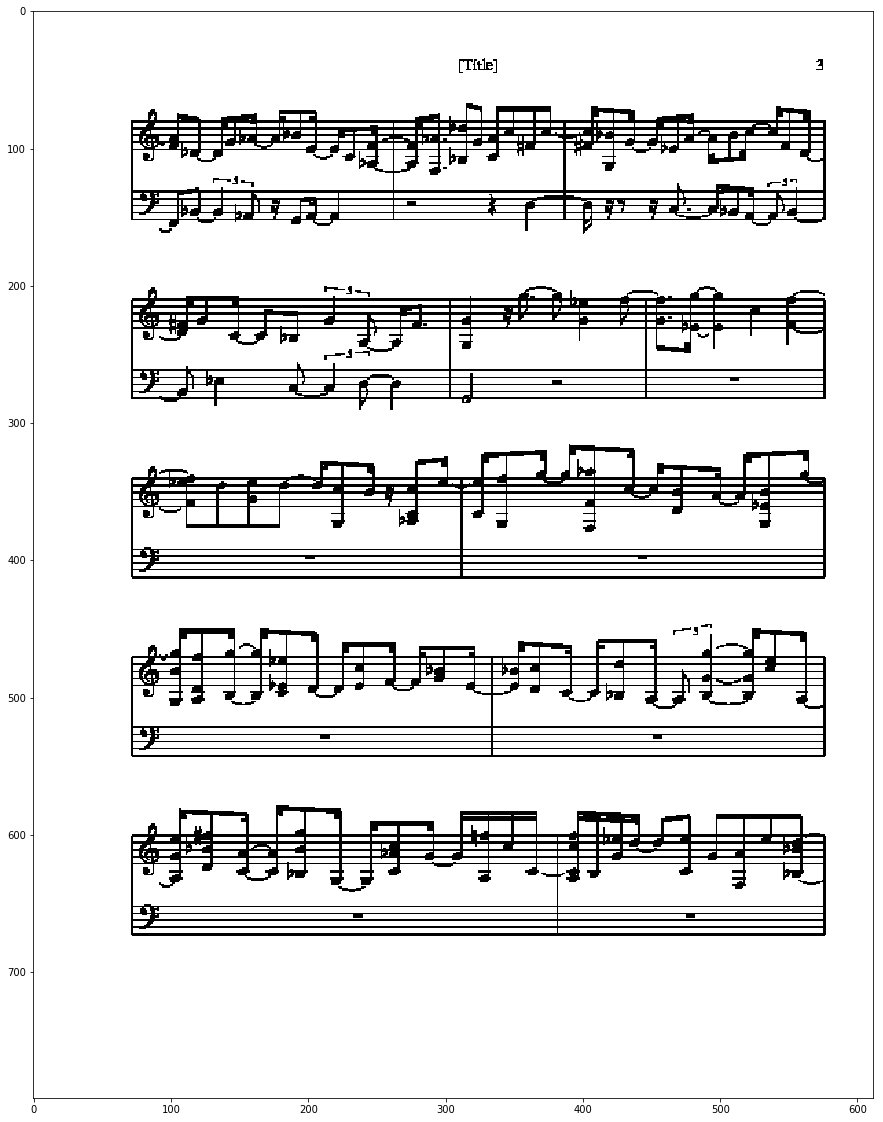

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(img_array, cmap="gray")

# Actual Things

In [8]:
test_png = os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-2.png")

In [5]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [6]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


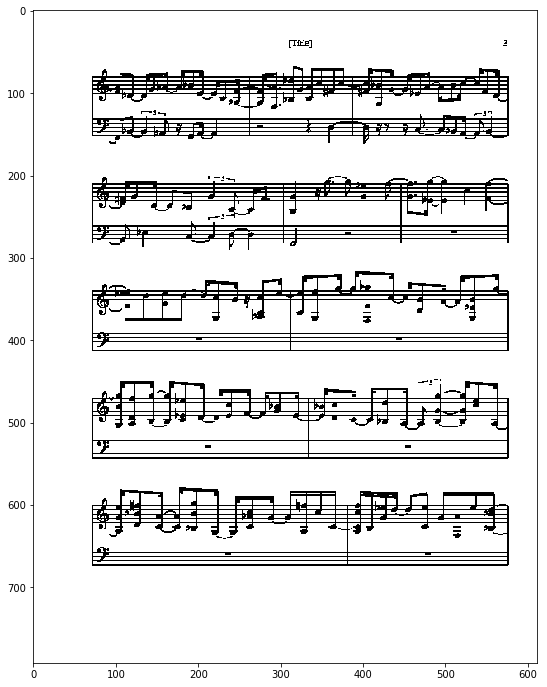

In [9]:
I = importImage(test_png)
showImage(I)

In [10]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

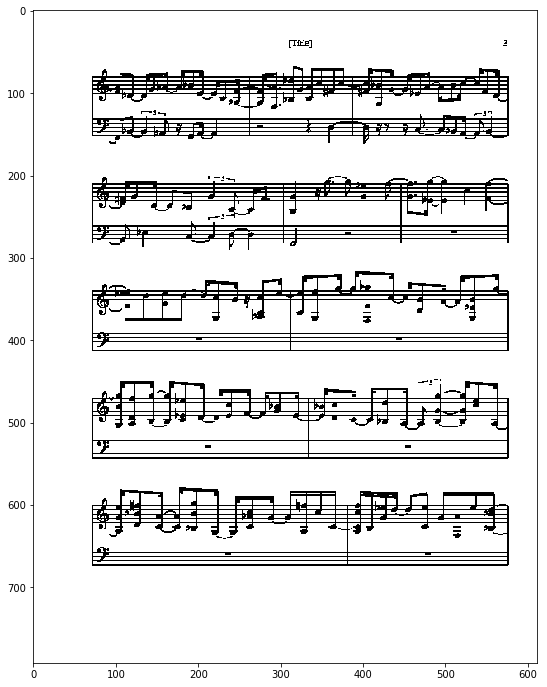

In [11]:
Irot, theta = rotateToHorizontal(I)
showImage(Irot)

In [12]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [13]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [14]:
def getCropped(X):
    ll, w, h = getBoundingBox(X)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

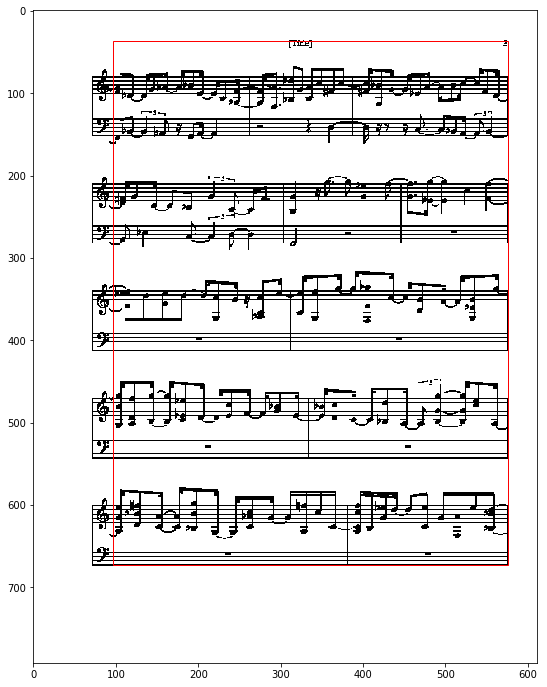

In [15]:
ll, bbw, bbh = getBoundingBox(Irot)
showImageWithBB(Irot, ll, bbw, bbh)

In [16]:
def getStripBoundaries(X, showPlot = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) - 1 
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i + 1]
        peak2idx = peakidxs[2*i + 2]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [17]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


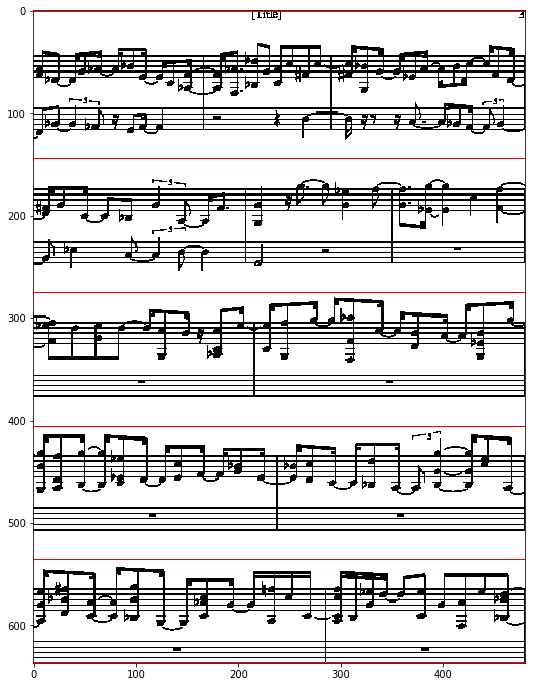

In [18]:
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop)
visualizeBoundaries(Icrop, bnds)